In [ ]:
! pip install tensorflow==2.4.1

     |████████████████████████████████| 394.3 MB 11 kB/s 
     |████████████████████████████████| 3.8 MB 37.3 MB/s 
     |████████████████████████████████| 462 kB 31.9 MB/s 
     |████████████████████████████████| 14.8 MB 37.2 MB/s 
     |████████████████████████████████| 132 kB 51.2 MB/s 
     |████████████████████████████████| 2.9 MB 33.1 MB/s 
  Created wheel for wrapt: filename=wrapt-1.12.1-cp37-cp37m-linux_x86_64.whl size=68720 sha256=ddbdef77c6ee1d62e5df47f9489a96204039ab6e71726187dff8a79047303d7d
  Stored in directory: /root/.cache/pip/wheels/62/76/4c/aa25851149f3f6d9785f6c869387ad82b3fd37582fa8147ac6
Successfully built wrapt
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 3.10.0.2
    Uninstalling typing-extensions-3.10.0.2:
      Successfully uninstalled typing-extensions-3.10.0.2
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.5
    Uninstalling numpy-1.21.5:
      Successfully uninstalled numpy-1.21.5
  A

In [ ]:
# Import tensorflow and print current version
import tensorflow as tf
print(tf.__version__)

2.4.1


In [ ]:
# Import rest of libraries used in the code. Usually this is done at the beginning of the document but it can be done at any position
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
import os
import random

In [ ]:
theSEED = 232323
tf.random.set_seed(theSEED)
np.random.seed(theSEED)
random.seed(theSEED)

In [ ]:
# Hyperparameters:
# They must be carefully select depending on the dataset and model

NB_EPOCH = 5       # Number of training epochs
VALIDATION_SPLIT=0.2 # Size of the validation split taken from the training set. If your dataset has validation split, skip this part.

Cargamos el dataset:

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
#!mkdir -p '/content/gdrive/MyDrive/Curso-Jetson/imagenes'

In [ ]:
#!gdown --id '14CuNJzfpF-HCOcgYXE1XF0umKIxCScB7' -O '/content/gdrive/MyDrive/Curso-Jetson/imagenes/fruits.zip'

Downloading...
From: https://drive.google.com/uc?id=14CuNJzfpF-HCOcgYXE1XF0umKIxCScB7
To: /content/gdrive/MyDrive/Curso-Jetson/imagenes/fruits.zip
100% 16.5M/16.5M [00:00<00:00, 87.9MB/s]


In [ ]:
!unzip '/content/gdrive/MyDrive/Curso-Jetson/imagenes/cartas.zip' -d '/content/gdrive/MyDrive/Curso-Jetson/imagenes/'

Archive:  /content/gdrive/MyDrive/Curso-Jetson/imagenes/cartas.zip
   creating: /content/gdrive/MyDrive/Curso-Jetson/imagenes/cartas/
   creating: /content/gdrive/MyDrive/Curso-Jetson/imagenes/cartas/sota/
  inflating: /content/gdrive/MyDrive/Curso-Jetson/imagenes/cartas/sota/000000000.png  
  inflating: /content/gdrive/MyDrive/Curso-Jetson/imagenes/cartas/sota/000000001.png  
  inflating: /content/gdrive/MyDrive/Curso-Jetson/imagenes/cartas/sota/000000002.png  
  inflating: /content/gdrive/MyDrive/Curso-Jetson/imagenes/cartas/sota/000000003.png  
  inflating: /content/gdrive/MyDrive/Curso-Jetson/imagenes/cartas/sota/000000004.png  
  inflating: /content/gdrive/MyDrive/Curso-Jetson/imagenes/cartas/sota/000000005.png  
  inflating: /content/gdrive/MyDrive/Curso-Jetson/imagenes/cartas/sota/000000006.png  
  inflating: /content/gdrive/MyDrive/Curso-Jetson/imagenes/cartas/sota/000000007.png  
  inflating: /content/gdrive/MyDrive/Curso-Jetson/imagenes/cartas/sota/000000008.png  
  inflating

In [ ]:
!ls '/content/gdrive/MyDrive/Curso-Jetson/imagenes/cables'

jack  usb-a  usb-c


In [ ]:
#!ls '/content/gdrive/MyDrive/Curso-Jetson/imagenes/fruits/Training'

Banana	Lemon  Orange  Strawberry


In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/gdrive/MyDrive/Curso-Jetson/imagenes/cartas', labels='inferred', subset="training", validation_split=VALIDATION_SPLIT, seed=0)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/gdrive/MyDrive/Curso-Jetson/imagenes/cartas', labels='inferred', subset="validation", validation_split=VALIDATION_SPLIT, seed=0)

Found 243 files belonging to 3 classes.
Using 195 files for training.
Found 243 files belonging to 3 classes.
Using 48 files for validation.


In [ ]:
train_ds

<BatchDataset shapes: ((None, 256, 256, 3), (None,)), types: (tf.float32, tf.int32)>

Vamos a visualizar una de las muestras y la clase a la que pertenece:

In [ ]:
def process(image,label):
    image = tf.image.resize(image, [224, 224])
    image = tf.cast(image/255. ,tf.float32)
    return image,label

train_ds = train_ds.map(process)
val_ds = val_ds.map(process)

In [ ]:
#resize_and_rescale = tf.keras.Sequential([
#  tf.keras.layers.experimental.preprocessing.Resizing(224, 224),
#  tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
#])

# otra forma de redimensionar y normalizar, meter capas a la red que hagan las operaciones de preprocesado

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

# esto es lo mismo pero metiendo capas de data augmentation, aleatoriamente les hace espejo y rotaciones

In [ ]:
# TRANSFER LEARNING TMB MEJORA OVERFITTING

# Create a pretrained model.
base_model = tf.keras.applications.MobileNetV2(
  input_tensor=None, include_top=False,     # QUE NO INCLUYA CLASIFICADOR
  weights='imagenet', input_shape=(224,224,3))
base_model.trainable = False

model = tf.keras.Sequential()
#model.add(resize_and_rescale)
# DATA AUG:
model.add(data_augmentation)
# PARTE PREENTRENADA
model.add(base_model)
# CLASIFICADOR
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(tf.keras.layers.Dense(300, activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(100, activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(3, activation='softmax')) # CAMBIAR NUMERO DE CLASES !!!!!

model.build((None, 224,224,3))
model.summary()

9412608/9406464 [==============================] - 0s 0us/step
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 300)               384300    
_________________________________________________________________
dropout (Dropout)            (None, 300)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________

In [ ]:
model.layers[0].summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
random_flip (RandomFlip)     (None, 224, 224, 3)       0         
_________________________________________________________________
random_rotation (RandomRotat (None, 224, 224, 3)       0         
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer=tf.keras.optimizers.SGD(lr=0.001, momentum=0.9),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_ds, epochs=NB_EPOCH, validation_data=val_ds)

Epoch 1/5
7/7 [==============================] - 25s 741ms/step - loss: 0.4072 - accuracy: 0.8504 - val_loss: 0.1110 - val_accuracy: 0.9792
Epoch 2/5
7/7 [==============================] - 15s 602ms/step - loss: 0.1808 - accuracy: 0.9218 - val_loss: 0.1082 - val_accuracy: 0.9792
Epoch 3/5
7/7 [==============================] - 16s 693ms/step - loss: 0.2387 - accuracy: 0.9262 - val_loss: 0.1072 - val_accuracy: 0.9583
Epoch 4/5
7/7 [==============================] - 15s 584ms/step - loss: 0.2761 - accuracy: 0.8912 - val_loss: 0.1148 - val_accuracy: 0.9583
Epoch 5/5
7/7 [==============================] - 20s 960ms/step - loss: 0.1726 - accuracy: 0.9564 - val_loss: 0.1070 - val_accuracy: 0.9792


In [ ]:
model.evaluate(val_ds)

2/2 [==============================] - 3s 67ms/step - loss: 0.1070 - accuracy: 0.9792


[0.10704121738672256, 0.9791666865348816]

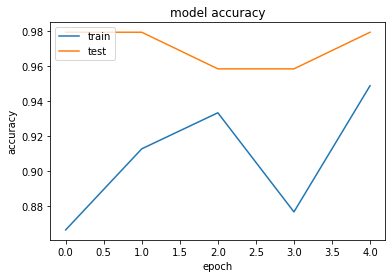

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

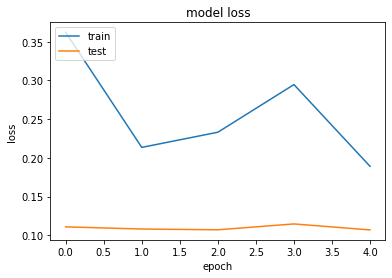

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
model.layers.pop(0)
#model.layers.pop(0)
newInput = tf.keras.layers.Input(batch_shape=(None,224,224,3))
newOutputs = model(newInput)
newModel = tf.keras.Model(newInput, newOutputs)
newModel.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 3)                 2672687   
Total params: 2,672,687
Trainable params: 414,703
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
newModel.layers[1].layers[0].summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
random_flip (RandomFlip)     (None, 224, 224, 3)       0         
_________________________________________________________________
random_rotation (RandomRotat (None, 224, 224, 3)       0         
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


In [ ]:
newModel.compile(optimizer=tf.keras.optimizers.SGD(lr=0.0001, momentum=0.9),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
newModel.evaluate(val_ds)

2/2 [==============================] - 6s 37ms/step - loss: 0.2590 - accuracy: 0.9132


[0.25326231122016907, 0.9166666865348816]

In [ ]:
# Save model
OUT_MODEL_PATH= '/content/gdrive/MyDrive/Curso-Jetson/models'
model.save(os.path.join(OUT_MODEL_PATH, 'model-final-cartas.hdf5'))
model.save(os.path.join(OUT_MODEL_PATH, 'model-final-cartas'))

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Curso-Jetson/models/model-final-cartas/assets


In [ ]:
!ls $OUT_MODEL_PATH

model-final-cables_inicial		   model-final-cartas
model-final-cables_inicial.hdf5		   model-final-cartas.hdf5
model-final-cables_inicial_jueves	   model-final-pract1
model-final-cables_inicial_jueves.hdf5	   model-final-pract1.hdf5
model-final-cables_inicial_jueves_v2	   model-final-pract2
model-final-cables_inicial_jueves_v2.hdf5  model-final-pract2.hdf5
